In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import yfinance as yf
import glob
import os
from scipy.optimize import minimize

Se tomará el mismo escenario que en la inversión pasiva, es decir, tomar los activos que tiene el NAFTRAC, el ETF de BlackRock que buscar replicar los resultados del S&P/BMV IPC. Y, la forma de plantear una estrategia de Inversión Activa, será considerando lo siguiente:

* Utiliza los activos para los cuales tienes su precio para todo el periodo 31-01-2020 a 29-07-2022
* Utiliza como base sólo los activos incluidos en la ponderación inicial del NAFTRAC en el 31-01-2020 y no utilices cualquier otro activo que se agregue al ETF en fechas posteriores.
* Cuando elimines activos por no contar con precios para todo el periodo necesario, contabiliza en CASH el capital que hayan tenido asignado por su ponderación en NAFTRAC.
* Con el capital que NO ES CASH, construye un portafolio eficiente, maximizando el sharpe estándar, empezando desde el  31-01-2021 y utilizando los rendimientos logartimicos diarios hasta el 31-01-2020
* A partir del siguiente mes inmediato al 29-07-2022, rebalancea, con los precios diarios, utilizando la siguiente regla:
* Disminuir en un 2.5% la posición en títulos de aquellos activos cuyo precio disminuyó un 5% o más
* Aumentar en un 2.5% la posición en títulos de aquellos activos cuyo precio aumentó un 5% o más
* Considera pagar las mismas comisiones por rebalanceo para cada cambio de posición con cada activo según aplique
* El orden de recompra será aquél activo con mayor crecimiento el día inmediato anterior

In [2]:
absolute_path = os.path.abspath(os.path.dirname('closing_prices.csv'))

closes=pd.read_csv(absolute_path + '\created_files\closing_prices.csv')
closes=closes.set_index('Date').drop(closes.columns[0],axis=1)
closes

AC.MX  ALFAA.MX   ALSEA.MX  AMXL.MX    ASURB.MX  BBAJIOO.MX  \
Date                                                                           
2020-01-31  107.120003     14.19  45.825001   15.695  363.149994   31.205000   
2020-02-04  108.879997     14.18  45.849998   15.990  365.799988   31.315001   
2020-02-05  107.470001     14.04  46.240002   15.890  372.700012   31.200001   
2020-02-06  107.620003     13.66  46.099998   15.680  369.670013   31.129999   
2020-02-07  107.610001     13.36  45.200001   15.640  366.769989   30.740000   
...                ...       ...        ...      ...         ...         ...   
2022-07-25  139.020004     14.10  38.910000   19.010  382.739990   45.500000   
2022-07-26  143.910004     13.59  38.290001   18.840  379.760010   45.770000   
2022-07-27  140.130005     14.03  38.580002   18.770  380.459991   46.990002   
2022-07-28  141.410004     14.23  39.189999   19.350  384.769989   47.590000   
2022-07-29  141.210007     14.01  39.660000   19.400  384.000000   47.939999   

            BIMBOA.MX  BOLSAA.MX  CEMEXCPO.MX  CUERVO.MX  ...    LABB.MX  \
Date                                                      ...              
2020-01-31  33.805000  43.439999        7.595  34.900002  ...  22.350000   
2020-02-04  34.285000  43.349998        7.945  35.919998  ...  22.450001   
2020-02-05  33.980000  42.840000        7.750  35.830002  ...  22.110001   
2020-02-06  33.130001  43.270000        7.750  34.639999  ...  21.900000   
2020-02-07  33.169998  43.009998        7.790  33.820000  ...  20.959999   
...               ...        ...          ...        ...  ...        ...   
2022-07-25  74.239998  35.490002        8.310  46.029999  ...  19.370001   
2022-07-26  74.070000  36.000000        8.000  46.410000  ...  18.709999   
2022-07-27  73.070000  37.380001        8.030  47.130001  ...  19.400000   
2022-07-28  75.080002  37.590000        8.130  47.349998  ...  19.320000   
2022-07-29  72.040001  37.939999        8.230  46.139999  ...  18.950001   

            LIVEPOLC-1.MX  MEGACPO.MX      MXN=X     OMAB.MX   ORBIA.MX  \
Date                                                                      
2020-01-31      99.714996   70.680000  18.780800  143.755005  44.410000   
2020-02-04      98.184998   71.044998  18.814400  144.490005  46.755001   
2020-02-05      96.519997   72.879997  18.671289  144.050003  46.869999   
2020-02-06      93.820000   70.730003  18.587601  145.020004  46.470001   
2020-02-07      94.000000   71.949997  18.639700  144.059998  46.110001   
...                   ...         ...        ...         ...        ...   
2022-07-25      89.320000   48.049999  20.534599  124.489998  43.820000   
2022-07-26      89.160004   47.689999  20.450701  120.959999  43.470001   
2022-07-27      89.589996   48.200001  20.453699  120.919998  42.299999   
2022-07-28      91.269997   47.779999  20.373301  124.400002  43.939999   
2022-07-29      91.480003   47.410000  20.281200  124.169998  44.959999   

            PE&OLES.MX   PINFRA.MX  TLEVISACPO.MX  WALMEX.MX  
Date                                                          
2020-01-31  197.339996  204.115005      41.965000  55.220001  
2020-02-04  199.929993  204.395004      42.320000  56.625000  
2020-02-05  196.190002  202.759995      40.950001  56.119999  
2020-02-06  193.059998  204.080002      40.369999  55.209999  
2020-02-07  193.199997  202.669998      40.029999  56.000000  
...                ...         ...            ...        ...  
2022-07-25  189.699997  142.979996      32.240002  71.860001  
2022-07-26  187.960007  142.500000      30.760000  70.760002  
2022-07-27  193.059998  143.839996      31.190001  71.459999  
2022-07-28  211.360001  145.199997      32.270000  73.599998  
2022-07-29  205.080002  147.039993      32.139999  73.839996  

[630 rows x 30 columns]

In [3]:
yearone=closes.iloc[0:251]
yearone

AC.MX  ALFAA.MX   ALSEA.MX  AMXL.MX    ASURB.MX  BBAJIOO.MX  \
Date                                                                           
2020-01-31  107.120003     14.19  45.825001   15.695  363.149994   31.205000   
2020-02-04  108.879997     14.18  45.849998   15.990  365.799988   31.315001   
2020-02-05  107.470001     14.04  46.240002   15.890  372.700012   31.200001   
2020-02-06  107.620003     13.66  46.099998   15.680  369.670013   31.129999   
2020-02-07  107.610001     13.36  45.200001   15.640  366.769989   30.740000   
...                ...       ...        ...      ...         ...         ...   
2021-01-25   96.019997     13.48  22.980000   14.610  321.959991   25.000000   
2021-01-26   95.989998     13.80  22.780001   14.450  329.170013   24.830000   
2021-01-27   94.570000     13.83  22.570000   14.230  328.500000   24.490000   
2021-01-28   94.949997     13.68  22.930000   14.050  324.950012   23.920000   
2021-01-29   93.070000     12.90  23.110001   13.670  322.529999   24.760000   

            BIMBOA.MX  BOLSAA.MX  CEMEXCPO.MX  CUERVO.MX  ...    LABB.MX  \
Date                                                      ...              
2020-01-31  33.805000  43.439999        7.595  34.900002  ...  22.350000   
2020-02-04  34.285000  43.349998        7.945  35.919998  ...  22.450001   
2020-02-05  33.980000  42.840000        7.750  35.830002  ...  22.110001   
2020-02-06  33.130001  43.270000        7.750  34.639999  ...  21.900000   
2020-02-07  33.169998  43.009998        7.790  33.820000  ...  20.959999   
...               ...        ...          ...        ...  ...        ...   
2021-01-25  42.250000  46.889999       12.430  47.490002  ...  21.940001   
2021-01-26  41.980000  46.779999       12.380  47.020000  ...  21.870001   
2021-01-27  40.480000  46.610001       11.840  45.070000  ...  22.250000   
2021-01-28  40.130001  46.150002       12.170  43.740002  ...  22.209999   
2021-01-29  38.520000  46.000000       11.760  43.730000  ...  20.990000   

            LIVEPOLC-1.MX  MEGACPO.MX      MXN=X     OMAB.MX   ORBIA.MX  \
Date                                                                      
2020-01-31      99.714996   70.680000  18.780800  143.755005  44.410000   
2020-02-04      98.184998   71.044998  18.814400  144.490005  46.755001   
2020-02-05      96.519997   72.879997  18.671289  144.050003  46.869999   
2020-02-06      93.820000   70.730003  18.587601  145.020004  46.470001   
2020-02-07      94.000000   71.949997  18.639700  144.059998  46.110001   
...                   ...         ...        ...         ...        ...   
2021-01-25      65.519997   75.360001  19.942881  121.040001  45.750000   
2021-01-26      65.650002   75.620003  20.105169  121.389999  46.680000   
2021-01-27      66.589996   75.639999  19.988300  118.730003  46.150002   
2021-01-28      65.980003   76.989998  20.331530  120.239998  46.090000   
2021-01-29      65.510002   74.120003  20.252251  120.989998  44.180000   

            PE&OLES.MX   PINFRA.MX  TLEVISACPO.MX  WALMEX.MX  
Date                                                          
2020-01-31  197.339996  204.115005      41.965000  55.220001  
2020-02-04  199.929993  204.395004      42.320000  56.625000  
2020-02-05  196.190002  202.759995      40.950001  56.119999  
2020-02-06  193.059998  204.080002      40.369999  55.209999  
2020-02-07  193.199997  202.669998      40.029999  56.000000  
...                ...         ...            ...        ...  
2021-01-25  316.440002  163.509995      34.759998  61.259998  
2021-01-26  321.640015  162.630005      35.540001  61.330002  
2021-01-27  299.589996  157.369995      33.040001  60.070000  
2021-01-28  300.910004  154.630005      33.099998  60.009998  
2021-01-29  306.750000  154.059998      30.990000  58.349998  

[251 rows x 30 columns]

In [4]:
#dataframe con medias y colatilidades por activo
summary=pd.DataFrame(columns=yearone.columns)
summary.loc['Media']=yearone.mean()
summary.loc['Volatilidad']=yearone.var()

#correlaciones
corr=yearone.corr()

#riskfree rate
rf=0.085

#matiz varianza-covarianza
S= np.diag(summary.loc['Volatilidad'].values)
Sigma=S.dot(corr).dot(S)
# rendimientos esperados activos individuales
re=summary.loc['Media'].values

In [5]:
# Función objetivo
def var(w,Sigma):
    return w.T.dot(Sigma).dot(w)
N=len(re)                                               # Número de activos
w0=np.ones(N)/N                                         # Dato inicial
bnds=((0,1),)*N                                         # Cotas de las variables
cons=({'type': 'eq', 'fun': lambda w: np.sum(w)-1},)    # Restricciones

In [6]:
# Portafolio de mínima varianza
minvar=minimize(var, w0, args=(Sigma,),bounds=bnds, constraints=cons)
w_minvar=minvar.x
E_minvar=re.T.dot(w_minvar)
s_minvar=var(w_minvar,Sigma)**0.5
RS_minvar=(E_minvar-rf)/s_minvar

In [7]:
# Función objetivo
def menos_RS(w,re,rf,Sigma):
    E_port=re.T.dot(w)
    s_port=var(w,Sigma)**0.5
    RS=(E_port-rf)/s_port
    return -RS

In [8]:
# Portafolio EMV
emv=minimize(menos_RS, w0, args=(re,rf,Sigma),bounds=bnds, constraints=cons)

In [9]:
# Pesos, rendimiento y riesgo del portafolio EMV
w_emv=emv.x
E_emv=re.T.dot(w_emv)
s_emv=var(w_emv,Sigma)**0.5
RS_emv=(E_emv-rf)/s_emv

In [10]:
w_minvar = minvar.x
E_minvar =re.T.dot(w_minvar)
s_minvar = var(w_minvar, Sigma)**0.5
RS_minvar= (E_minvar - rf) / s_minvar

In [11]:
cov_emv_minvar=w_emv.T.dot(Sigma).dot(w_minvar)
corr_emv_minvar=cov_emv_minvar/(s_emv*s_minvar)
w_p=np.linspace(0,1)
frontera = pd.DataFrame(data={'Media' : w_p*E_emv + (1-w_p)*E_minvar,
                             'Vol': ((w_p*s_emv)*2 +((1-w_p)*s_minvar)**2 + 2 * w_p * (1-w_p)*cov_emv_minvar)*0.5})
frontera['RS']=(frontera['Media'] - rf)/frontera['Vol']
frontera.head()

Media           Vol        RS
0  120.264336  36761.519387  0.003269
1  118.242858  35277.258478  0.003349
2  116.221380  33823.582534  0.003434
3  114.199901  32400.491554  0.003522
4  112.178423  31007.985540  0.003615

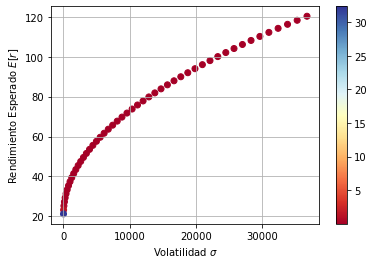

In [12]:
plt.figure(figsize=(6,4))
plt.scatter(frontera['Vol'],frontera['Media'],c=frontera['RS'],cmap='RdYlBu')
plt.grid()
plt.xlabel('Volatilidad $\sigma$')
plt.ylabel('Rendimiento Esperado $E[r]$')
plt.colorbar()

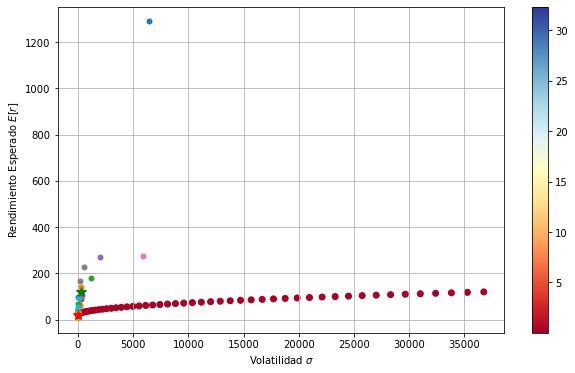

In [13]:
plt.figure(figsize=(10,6))
# Frontera
plt.scatter(frontera['Vol'], frontera['Media'], c=frontera['RS'], cmap = 'RdYlBu', label = 'Frontera de min var')
# Activos ind
for activo in list(summary.columns):
    plt.plot(summary.loc['Volatilidad', activo],
             summary.loc['Media', activo],
             'o',
             ms=5,
            label = activo)
# Port. óptimos
plt.plot(s_minvar, E_minvar, '*g', ms=10, label='Portafolio de min var')
plt.plot(s_emv, E_emv, '*r', ms=10, label='Portafolio eficiente en media var')
plt.xlabel('Volatilidad $\sigma$')
plt.ylabel('Rendimiento Esperado $E[r]$')
plt.grid()
#plt.legend(loc='best')
plt.colorbar()

In [14]:
k=1000000
Peficiente=pd.DataFrame(columns=summary.columns)
Peficiente.loc['Pesos%']=w_emv*100
Peficiente.loc['Postura']=Peficiente.iloc[0,:].values/100*k
Peficiente.loc['Precio']=yearone.iloc[-1,:]
Peficiente.loc['Titulos']=round(Peficiente.loc['Postura']/Peficiente.loc['Precio'])
Peficiente=Peficiente.T.reset_index()
Peficiente

index     Pesos%        Postura       Precio  Titulos
0           AC.MX   0.073149     731.486710    93.070000      8.0
1        ALFAA.MX   6.995948   69959.483343    12.900000   5423.0
2        ALSEA.MX   0.354470    3544.695961    23.110001    153.0
3         AMXL.MX  14.392182  143921.822766    13.670000  10528.0
4        ASURB.MX   0.002500      24.998963   322.529999      0.0
5      BBAJIOO.MX   0.000003       0.034733    24.760000      0.0
6       BIMBOA.MX   0.399233    3992.332943    38.520000    104.0
7       BOLSAA.MX   0.000769       7.687816    46.000000      0.0
8     CEMEXCPO.MX   1.518705   15187.046224    11.760000   1291.0
9       CUERVO.MX   0.758689    7586.888821    43.730000    173.0
10     ELEKTRA.MX   0.003151      31.505877  1386.010010      0.0
11    FEMSAUBD.MX   0.000028       0.282426   139.699997      0.0
12        GAPB.MX   0.000508       5.078005   206.600006      0.0
13    GCARSOA1.MX   0.000003       0.033295    51.590000      0.0
14    GFINBURO.MX   0.000003       0.025247    18.280001      0.0
15    GFNORTEO.MX   0.001020      10.200898   101.570000      0.0
16    GMEXICOB.MX   0.000132       1.323441    87.839996      0.0
17      GRUMAB.MX   0.004267      42.673400   225.059998      0.0
18     KIMBERA.MX   2.212674   22126.738434    35.810001    618.0
19      KOFUBL.MX   0.000047       0.467158    88.919998      0.0
20        LABB.MX   4.681925   46819.248199    20.990000   2231.0
21  LIVEPOLC-1.MX   0.254559    2545.593647    65.510002     39.0
22     MEGACPO.MX   0.784047    7840.471627    74.120003    106.0
23          MXN=X  65.865609  658656.090610    20.252251  32523.0
24        OMAB.MX   0.000171       1.710806   120.989998      0.0
25       ORBIA.MX   0.000059       0.589106    44.180000      0.0
26     PE&OLES.MX   0.002941      29.412434   306.750000      0.0
27      PINFRA.MX   0.000566       5.662508   154.059998      0.0
28  TLEVISACPO.MX   2.627547   26275.473481    30.990000    848.0
29      WALMEX.MX   0.001766      17.656722    58.349998      0.0

In [15]:
K=1000000
df_activa=pd.DataFrame(columns=['timestamp','capital','rend','rend_acum'])
df_activa.iloc[:,0]=yearone.index
dates=yearone.index.tolist()
c=yearone.T.mul(Peficiente.iloc[:,4].values, axis = 0) 
for i in range(len(dates)):
    df_activa.iloc[i,1]=c.iloc[:,i].sum()
df_activa['rend']=df_activa['capital'].pct_change().fillna((df_activa.iloc[0,1]-k)/df_activa.iloc[0,1])
df_activa['rend_acum']=df_activa['rend'].cumsum()  
df_activa

timestamp         capital      rend  rend_acum
0    2020-01-31  1001193.245427  0.001192   0.001192
1    2020-02-04  1006481.222856  0.005282   0.006473
2    2020-02-05   997917.842776 -0.008508  -0.002035
3    2020-02-06   989359.629065 -0.008576  -0.010611
4    2020-02-07   986310.589291 -0.003082  -0.013693
..          ...             ...       ...        ...
246  2021-01-25  1019959.760372  0.013312   0.032308
247  2021-01-26  1026258.424353  0.006175   0.038484
248  2021-01-27  1017527.597841 -0.008507   0.029976
249  2021-01-28  1026076.628403  0.008402   0.038378
250  2021-01-29  1009222.728193 -0.016426   0.021953

[251 rows x 4 columns]

In [16]:
yeartwo=closes.iloc[251:]
dates=yeartwo.index.tolist()

In [17]:
df_operaciones=pd.DataFrame(columns=['timestamp','titulos_totatles','titulos_compra','comision','comision_acum'])
df_operaciones['timestamp']=dates
c=[]
com= 0.00125
for i in range(len(dates)):
    df_operaciones.iloc[i,1]=round((w_emv*k)/yeartwo.iloc[i,:]).sum()
    c.append(round((w_emv*k)/yeartwo.iloc[i,:]))
for j in range(len(dates)-1):  
    change=(yeartwo.iloc[j,:]/yeartwo.iloc[j+1,:])-1
    for i in range(len(w_emv)-1):
        if change[i]>=0.05:
            c[j+1][i]=c[j+1][i]*(1-0.025)
            df_operaciones.iloc[i+1,2]=sum(c[j+1])
            df_operaciones.iloc[i+1,3]=(c[i+1]*yeartwo.iloc[i+1,:]*com).sum()
#         if change[i]<0.05:
#             c[j+1][i]=c[j+1][i]*(1+0.025)
#             df_operaciones.iloc[i+1,2]=sum(c[j+1])
    
df_operaciones

timestamp titulos_totatles titulos_compra     comision comision_acum
0    2021-02-02          54066.0            NaN          NaN           NaN
1    2021-02-03          54389.0       50787.85  1261.554577           NaN
2    2021-02-04          53964.0       51296.65  1261.495416           NaN
3    2021-02-05          53846.0       51750.65   1261.47322           NaN
4    2021-02-08          54458.0      50203.825  1261.539005           NaN
..          ...              ...            ...          ...           ...
374  2022-07-25          50940.0            NaN          NaN           NaN
375  2022-07-26          51522.0            NaN          NaN           NaN
376  2022-07-27          51272.0            NaN          NaN           NaN
377  2022-07-28          51043.0            NaN          NaN           NaN
378  2022-07-29          51266.0            NaN          NaN           NaN

[379 rows x 5 columns]

In [18]:
# plt.figure(figsize=(12.2,4.5)) 
# for i in ret.columns.values:
#     plt.hist( ret[i],  label=i, bins = 200)
# plt.title('Histograma de los retornos')
# plt.xlabel('Fecha',fontsize=18)
# plt.ylabel('Precio en USD',fontsize=18)
# plt.legend(ret.columns.values)
# plt.show()